## Imports

In [1]:
# modify from https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/22_Image_Captioning.ipynb

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from keras.callbacks import TensorBoard

Using TensorFlow backend.


## Configuration

In [3]:
config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.5
K.tensorflow_backend.set_session(tf.Session(config=config))

state_size=512,
embedding_size=300,
factored_size=512,
learning_rate=0.0002,
beta_1=0.9,
beta_2=0.999,
epsilon=1e-08,
lstm_layers=1
batch_size=64

## Load Data

path format :
    - /img/ -- contain images
    - /cache/ -- contain cache
    - /captions.json -- contain all captions data
    - /factual
        - /captions.json -- only contain list of list captions
        - /filenames.json -- list of filenames
        - train.txt -- indexes for train
        - val.txt -- indexes for validation
        - test.txt -- indexes for test

format captions.json (all captions data version):
    - {
        'image_id': 331-flickr,
        'filename': 000123.jpg,
        'captions': [
            {'id': 'Bahasa Indonesia',
             'en' : 'English'},
            ...
        ],
        'emotions': {
            'happy': 'Emosi happy',
            'sad': 'Emosi sad',
            'angry': 'Emosi angry'
        }
      }

In [4]:
from preparation import invoke_emotion_to_dataset, invoke_edited_to_dataset, load_caption

path = './dataset'
flickr_folder = path + '/flickr10k'

all_filenames = {
    'factual': [],
    'happy': [],
    'sad': [],
    'angry': []
}
all_captions = {
    'factual': [],
    'happy': [],
    'sad': [],
    'angry': []
}

modes = ['happy', 'sad', 'angry']
captions = []
filenames = []
for mode in modes + ['factual']:
    train, val, test = load_caption(flickr_folder + '/' + mode)
    filenames_train, captions_train = train
    filenames_val, captions_val = val
    filenames_test, captions_test = test
    if mode == 'factual':
        filenames += filenames_train + filenames_val + filenames_test
    captions += captions_train + captions_val + captions_test

# for test only
filenames_train, captions_train = filenames_train[:50], captions_train[:50]
filenames_val, captions_val = filenames_val[50:55], captions_val[50:55]
filenames_test, captions_test = filenames_test[55:60], captions_test[55:60]

num_images_train = len(filenames_train)
num_images_train

50

### Loading and Showing Images

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from images import load_image

In [6]:
def show_image(idx, folder_path, train):

    if train:
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        filename = filenames_val[idx]
        captions = captions_val[idx]

    path = folder_path + '/img/' + filename

    for caption in captions:
        print(caption)

    img = load_image(path)
    plt.imshow(img)
    plt.show()

### Example Image

Wanita menulis di sebuah pad di kamar dengan emas, dihiasi dinding.
Seorang wanita berdiri di dekat dinding yang dihias menulis.
Dindingnya dilapisi emas dan pola.
seorang wanita di balik dinding yang digulir sedang menulis
Seseorang berdiri di dekat dinding emas.


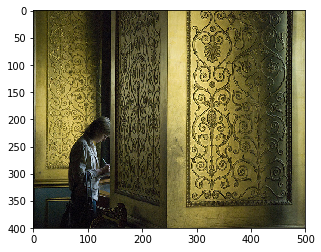

In [7]:
show_image(idx=0, folder_path=flickr_folder, train=True)

## Pre-Trained Image Model (ResNet152)

In [8]:
from model import EncoderResNet152
from keras import backend as K
encoder_resnet152 = EncoderResNet152()

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
img_size = K.int_shape(encoder_resnet152.model.input)[1:3]
transfer_values_size = K.int_shape(encoder_resnet152.model.output)[1]
print('img_size', img_size)
print('transfer_values_size', transfer_values_size)

img_size (224, 224)
transfer_values_size 2048


## Load pretrained image

In [10]:
from images import process_images_all

In [11]:
%%time
transfer_values = process_images_all(folder_path=flickr_folder,
                                     filenames=filenames,
                                     img_size=img_size,
                                     transfer_values_size=transfer_values_size,
                                     image_model_transfer=encoder_resnet152.model,
                                     batch_size=64)
print(len(transfer_values))

Processing 10000 images ...
10000
CPU times: user 74.7 ms, sys: 39.4 ms, total: 114 ms
Wall time: 117 ms


## Tokenizer

In [12]:
from tokenizer import mark_captions, flatten, TokenizerWrap, mark_start, mark_end

In [13]:
%%time
captions_marked = mark_captions(captions)
captions_flat = flatten(captions_marked)
tokenizer = TokenizerWrap(texts=captions_flat)
num_words = len(tokenizer.word_index)
print(num_words)

11360
CPU times: user 981 ms, sys: 11 ms, total: 992 ms
Wall time: 998 ms


In [14]:
%%time
captions_train_marked = mark_captions(captions_train)
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

CPU times: user 4.15 ms, sys: 25 µs, total: 4.18 ms
Wall time: 4.27 ms


In [15]:
%%time
captions_val_marked = mark_captions(captions_val)
tokens_val = tokenizer.captions_to_tokens(captions_val_marked)

CPU times: user 542 µs, sys: 14 µs, total: 556 µs
Wall time: 621 µs


In [16]:
%%time
captions_test_marked = mark_captions(captions_test)
tokens_test = tokenizer.captions_to_tokens(captions_test_marked)

CPU times: user 659 µs, sys: 9 µs, total: 668 µs
Wall time: 690 µs


In [17]:
token_start = tokenizer.word_index[mark_start.strip()]
token_end = tokenizer.word_index[mark_end.strip()]
print('token_start', token_start)
print('token_end', token_end)

token_start 1
token_end 2


## Data Generator

In [18]:
from generator import batch_generator

In [19]:
batch_size = 2

In [20]:
generator_train = batch_generator(batch_size=batch_size,
                                  filenames=filenames_train,
                                  transfer_values=transfer_values,
                                  tokens=tokens_train,
                                  with_transfer_values=True)

In [21]:
generator_val = batch_generator(batch_size=batch_size,
                                filenames=filenames_val,
                                transfer_values=transfer_values,
                                tokens=tokens_val,
                                with_transfer_values=True)

In [22]:
generator_test = batch_generator(batch_size=batch_size,
                                filenames=filenames_test,
                                transfer_values=transfer_values,
                                tokens=tokens_test,
                                with_transfer_values=True)

In [23]:
generator_prediction = batch_generator(batch_size=batch_size,
                                filenames=filenames_test,
                                transfer_values=transfer_values,
                                tokens=tokens_test,
                                with_transfer_values=True,
                                for_prediction=True)

### Steps Per Epoch

In [24]:
import numpy as np
num_captions_train = [len(captions) for captions in captions_train]
total_num_captions_train = np.sum(num_captions_train)
num_captions_val = [len(captions) for captions in captions_val]
total_num_captions_val = np.sum(num_captions_val)
num_captions_test = [len(captions) for captions in captions_test]
total_num_captions_test = np.sum(num_captions_test)
train_steps = int(total_num_captions_train / batch_size)
val_steps = int(total_num_captions_val / batch_size)
test_steps = int(total_num_captions_test / batch_size)
print('train steps', train_steps)
print('val steps', val_steps)
print('test steps', test_steps)

train steps 125
val steps 12
test steps 12


## Create NIC and StyleNet

In [25]:
from model import NIC, StyleNet
state_size = 128
embedding_size = 300
factored_size = 128
layer_size = 1
nic = NIC(injection_mode='pre',
          num_words=num_words,
          state_size=state_size,
          embedding_size=embedding_size,
          lstm_layers=layer_size)
stylenet = StyleNet(injection_mode='pre',
                    num_words=num_words,
                    include_transfer_value=True,
                    mode='factual',
                    state_size=state_size,
                    embedding_size=embedding_size,
                    factored_size=factored_size,
                    lstm_layers=layer_size)

### Callback Functions

In [26]:
from callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard

In [27]:
path_checkpoint = 'checkpoints/{}.checkpoint.id.layer{}.factored{}.state{}.embedding{}.keras'.format('flickr',
                                                                                                    layer_size,
                                                                                                    factored_size,
                                                                                                    state_size,
                                                                                                    embedding_size)
callback_checkpoint = ModelCheckpoint(stylenet,
                                      filepath=path_checkpoint)
log_dir = ('./logs/{mode}/'
           '{dataset}_epoch_{start_from}_{to}_layer{layer_size}_factored{factored_size}_'
           'state{state_size}_embedding{embedding_size}').format(mode='factual',
                                                                 dataset='flickr',
                                                                 start_from=0,
                                                                 to=3,
                                                                 layer_size=layer_size,
                                                                 factored_size=factored_size,
                                                                 state_size=state_size,
                                                                 embedding_size=embedding_size)
callback_tensorboard = TensorBoard(log_dir=log_dir,
                                   histogram_freq=0,
                                   write_graph=False)

In [28]:
callbacks = [callback_checkpoint, callback_tensorboard]

### Load Checkpoint

In [29]:
try:
    stylenet.load(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

### Train the Model

In [ ]:
%%time
stylenet.model.fit_generator(generator=generator_train,
                             steps_per_epoch=train_steps,
                             epochs=0,
                             validation_data=generator_val,
                             validation_steps=val_steps,
                             callbacks=callbacks)

In [30]:
scores = stylenet.model.evaluate_generator(
        generator=generator_test, steps=test_steps, verbose=1)
print('test loss', scores)

12/12 [==============================] - 1s 100ms/step
test loss 5.44200325012207


In [31]:
predicts = stylenet.model.predict_generator(
        generator=generator_prediction, steps=test_steps, verbose=1)

12/12 [==============================] - 1s 102ms/step


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [ ]:
predicts

## Generate Captions

In [ ]:
def generate_caption(image_path, max_tokens=30):
    image = load_image(image_path, size=img_size)
    image_batch = np.expand_dims(image, axis=0)
    transfer_values = image_model_transfer.predict(image_batch)

    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    token_int = token_start
    output_text = ''
    count_tokens = 0

    while token_int != token_end and count_tokens < max_tokens:
        decoder_input_data[0, count_tokens] = token_int
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }
        decoder_output = decoder_model.predict(x_data)
        
        token_onehot = decoder_output[0, count_tokens, :]
        token_int = np.argmax(token_onehot)
        sampled_word = tokenizer.token_to_word(token_int)

        output_text += " " + sampled_word
        
        count_tokens += 1

    output_tokens = decoder_input_data[0]

    plt.imshow(image)
    plt.show()
    
    print("Predicted caption:")
    print(output_text)
    print()

### Examples

In [ ]:
generate_caption(flickr_folder + '/img/' + filenames_train[0])

In [ ]:
generate_caption(flickr_folder + '/img/' + filenames_val[0])

In [ ]:
def generate_caption_all(folder_path, idx, train=False):
    if train:
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        filename = filenames_val[idx]
        captions = captions_val[idx]

    path = folder_path + '/img/' + filename

    generate_caption(path)

    print("True captions:")
    for caption in captions:
        print(caption)

In [ ]:
generate_caption_all(folder_path=flickr_folder, idx=1, train=True)

In [ ]:
generate_caption_all(folder_path=flickr_folder, idx=10, train=True)

In [ ]:
generate_caption_all(folder_path=flickr_folder, idx=1, train=False)

In [ ]:
from preparation import load_caption
from model import EncoderResNet152
from keras import backend as K
from images import process_images_all
from tokenizer import mark_captions, flatten, TokenizerWrap
from generator import batch_generator
from model import StyleNet
from callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
import tensorflow as tf
import numpy as np
import keras

keras.backend.clear_session()

config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.5
K.tensorflow_backend.set_session(tf.Session(config=config))

path = './dataset'
flickr_folder = path + '/flickr10k'

all_filenames = {'factual': [], 'happy': [], 'sad': [], 'angry': []}
all_captions = {'factual': [], 'happy': [], 'sad': [], 'angry': []}

modes = ['happy', 'sad', 'angry']
captions = []
filenames = []
for mode in modes + ['factual']:
    train, val, test = load_caption(flickr_folder + '/' + mode)
    filenames_train, captions_train = train
    filenames_val, captions_val = val
    filenames_test, captions_test = test
    if mode == 'factual':
        filenames += filenames_train + filenames_val + filenames_test
    captions += captions_train + captions_val + captions_test

num_images_train = len(filenames_train)

encoder_resnet152 = EncoderResNet152()

img_size = K.int_shape(encoder_resnet152.model.input)[1:3]
transfer_values_size = K.int_shape(encoder_resnet152.model.output)[1]
print('img_size', img_size)
print('transfer_values_size', transfer_values_size)

transfer_values = process_images_all(
    folder_path=flickr_folder,
    filenames=filenames,
    img_size=img_size,
    transfer_values_size=transfer_values_size,
    image_model_transfer=encoder_resnet152.model,
    batch_size=64)
print(len(transfer_values))

captions_marked = mark_captions(captions)
captions_flat = flatten(captions_marked)
tokenizer = TokenizerWrap(texts=captions_flat)
num_words = len(tokenizer.word_index)
print(num_words)

state_size = 512
embedding_size = 300
factored_size = 512
learning_rate = 0.0002
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-08
lstm_layers = 1
batch_size = 2
mode = 'factual'
train, val, test = load_caption(flickr_folder + '/' + mode)
filenames_train, captions_train = train
filenames_val, captions_val = val
filenames_test, captions_test = test

# for local testing only
filenames_train, captions_train = filenames_train[:50], captions_train[:50]
filenames_val, captions_val = filenames_val[50:55], captions_val[50:55]
filenames_test, captions_test = filenames_test[55:60], captions_test[55:60]

num_captions_train = [len(captions) for captions in captions_train]
total_num_captions_train = np.sum(num_captions_train)
num_captions_val = [len(captions) for captions in captions_val]
total_num_captions_val = np.sum(num_captions_val)
train_steps = int(total_num_captions_train / batch_size)
val_steps = int(total_num_captions_val / batch_size)
print('train steps', train_steps)
print('val steps', val_steps)

captions_train_marked = mark_captions(captions_train)
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

captions_val_marked = mark_captions(captions_val)
tokens_val = tokenizer.captions_to_tokens(captions_val_marked)

generator_train = batch_generator(
    batch_size=batch_size,
    filenames=filenames_train,
    transfer_values=transfer_values,
    tokens=tokens_train,
    with_transfer_values=mode == 'factual')

generator_val = batch_generator(
    batch_size=batch_size,
    filenames=filenames_val,
    transfer_values=transfer_values,
    tokens=tokens_val,
    with_transfer_values=mode == 'factual')

#     stylenet = StyleNet(
#         injection_mode='pre',
#         num_words=num_words,
#         include_transfer_value=mode == 'factual',
#         mode=mode,
#         state_size=state_size,
#         embedding_size=embedding_size,
#         factored_size=factored_size,
#         lstm_layers=lstm_layers)

#     path_checkpoint = 'checkpoints/{}.checkpoint.id.layer{}.factored{}.state{}.embedding{}.keras'.format(
#         'flickr', lstm_layers, factored_size, state_size, embedding_size)
#     callback_checkpoint = ModelCheckpoint(stylenet, filepath=path_checkpoint)
#     log_dir = (
#         './logs/{mode}/'
#         '{dataset}_epoch_{start_from}_{to}_layer{layer_size}_factored{factored_size}_'
#         'state{state_size}_embedding{embedding_size}').format(
#             mode='factual',
#             dataset='flickr',
#             start_from=0,
#             to=3,
#             layer_size=lstm_layers,
#             factored_size=factored_size,
#             state_size=state_size,
#             embedding_size=embedding_size)
#     callback_tensorboard = TensorBoard(
#         log_dir=log_dir, histogram_freq=0, write_graph=False)

#     callbacks = [callback_checkpoint, callback_tensorboard]

#     stylenet.model.fit_generator(
#         generator=generator_train,
#         steps_per_epoch=train_steps,
#         epochs=3,
#         validation_data=generator_val,
#         validation_steps=val_steps)


In [ ]:
stylenet = StyleNet(
    injection_mode='pre',
    num_words=num_words,
    include_transfer_value=True,
    mode=mode,
    state_size=state_size,
    embedding_size=embedding_size,
    factored_size=factored_size,
    lstm_layers=lstm_layers)

In [ ]:
stylenet.model.fit_generator(
    generator=generator_train,
    steps_per_epoch=train_steps,
    epochs=3,
    validation_data=generator_val,
    validation_steps=val_steps)